### This script uses bootstrap technique to produce some AOD plots


In [2]:
# Import python modules !!!!!
# from __future__ import unicode_literals
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True

import scipy as sp
import scipy.stats as stats
import numpy as np
import os
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def AngstromExponent(AOD_lambda1, AOD_lambda2, lambda1, lambda2):
    """Describes how AOD changes with wavelength (nm)"""

    alpha = - np.log(AOD_lambda1/AOD_lambda2)/np.log(lambda1/lambda2)

    return alpha
#
def scaled_AOD(alpha, AOD_old,lambda_old, lambda_new):
    """Computes new AOD at a given wavelength (nm)"""

    AOD_new = AOD_old*(float(lambda_new)/float(lambda_old))**(-alpha)

    return AOD_new, alpha

In [4]:
#

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1]: M. Duarte.  "Curve fitting," JUpyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t*s_err*np.sqrt(1/n + (x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    ax.fill_between(x2, y2+ci, y2-ci, color="#b9cfe7", edgecolor="")

    return ax

#
def plot_ci_bootstrap(n, x, y, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint
    nx = n 

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid)-1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(x, y + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(x, sp.polyval(pc,x), "b-", linewidth=2, alpha=3.0/float(nboot))

    return ax

In [5]:
def plots(heights, weights, in_text, xlabel='', ylabel='', add_xlim=[0,0]):
    x = heights
    y = weights
    s0 = in_text[0]    #  start
    s1 = in_text[1]    #  end
    ds = in_text[-1]   # delta

    # Modeling with Numpy
    p, cov = np.polyfit(x, y, 1, cov=True)        # parameters and covariance from of the fit
    print p
#     print "y = {} (+/- {}) * x + {} (+/- {})".format(m[0], np.sqrt(b[0][0]),m[1], np.sqrt(b[1][1]))
    print r"y_fit = {}*x + {}".format(p[0],p[1])
    print r"$y_{fit} =%0.4f*x + %0.4f$" %(p[0],p[1])

    y_model = np.polyval(p, x)                    # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = weights.size                              # number of observations
    m = p.size                                    # number of parameters
    DF = n - m                                    # degrees of freedom
    t = stats.t.ppf(0.95, n - m)                  # used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid/y_model)**2)             # chi-squared; estimates error in data
    chi2_red = chi2/(DF)                          # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2)/(DF))        # standard deviation of the error


    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8,6))

    # Data
    ax.plot(x,y,"o", color="#b9cfe7", markersize=8,
             markeredgewidth=1,markeredgecolor="b",markerfacecolor="None")

    # Fit
    ax.plot(x,y_model,"-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit") 
#     r"$y_fit = {}*x + {}$".format(p[0],p[1])
    ax.text(s0, s1, r"Reg. equation: $y_{fit} =%0.4f*x + %0.4f$" %(p[0],p[1]), fontsize=15)
#     # correction Coefficent
    ax.text(s0, s1-ds, r"Pearson Corr.: $\rho = %0.2f$" %(np.corrcoef(x,y)[0,1]), fontsize=15)
#     print np.corrcoef(x,y)
    ax.text(s0, s1-2*ds, r"Data Size: $N = %i$" %(len(x)), fontsize=15)

#     ax.text(0.2, 0.55, r'Reg. equation: $y_{fit} =%0.4f*x + %0.4f$' %(p[0],p[1]), fontsize=15)
#     # correction Coefficent
#     ax.text(0.2, 0.53, r'Pearson Corr.: $\rho = %0.2f$' %(np.corrcoef(x,y)[0,1]), fontsize=15)
#     print np.corrcoef(x,y)
#     ax.text(0.2, 0.51, r'Date Size: $N = %i$' %(len(x)), fontsize=15)
    
#     ax.annotate('local max', xy=(1.5, 0.5), xytext=(3, 1.5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = np.linspace(np.min(y_model), np.max(y_model), 100)

    # Confidence Interval (select one)
    plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
    #plot_ci_bootstrap(n, x, y, resid, ax=ax)

    # Prediction Interval
    pi = t*s_err*np.sqrt(1+1/n+(x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))   
    ax.fill_between(x2, y2+pi, y2-pi, color="None", linestyle="--")
    ax.plot(x2, y2-pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2+pi, "--", color="0.5")


    # Figure Modifications --------------------------------------------------------
    # Borders
    ax.spines["top"].set_color("0.5")
    ax.spines["bottom"].set_color("0.5")
    ax.spines["left"].set_color("0.5")
    ax.spines["right"].set_color("0.5")
    ax.get_xaxis().set_tick_params(direction="out")
    ax.get_yaxis().set_tick_params(direction="out")
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left() 

    # Labels
#     plt.title("Fit Plot for Weight", fontsize="14", fontweight="bold")
    plt.xlabel("%s" %xlabel,fontsize="14", fontweight="bold")
    plt.ylabel("%s" %ylabel,fontsize="14", fontweight="bold")
#     plt.xlim(np.min(x)-1,np.max(x)+1)
    plt.xlim(np.min(x)+add_xlim[0],np.max(x)+add_xlim[-1])
#     plt.xlim(np.min(x),np.max(x))

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    display = (0,1)
    anyArtist = plt.Line2D((0,1),(0,0), color="#b9cfe7")  # Create custom artists
    legend_properties = {'weight':'bold'}
    legend = plt.legend(
              [handle for i,handle in enumerate(handles) if i in display]+[anyArtist],
              [label for i,label in enumerate(labels) if i in display]+["95% Confidence Limits"],
              loc=9, bbox_to_anchor=(0, -0.21, 1., .102), ncol=3, mode="expand",
                fontsize="14")  
    frame = legend.get_frame().set_edgecolor("0.5")

    # Save Figure
    plt.tight_layout()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")

#### 1.1 Observerd from 500 - 550 nm

[ True  True  True False  True False False  True  True  True  True  True
 False  True False  True  True False False False  True False  True  True
  True  True  True  True False  True False  True  True  True  True False
  True False  True  True  True  True  True  True False  True False  True
  True  True  True  True  True False False  True  True  True  True False
 False  True False  True  True False  True False  True False False False
 False False  True False False False False  True False  True  True False
 False False False  True False False  True False False False False False
  True False  True False  True False False  True  True False  True False
 False  True False  True  True  True  True  True False False False  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

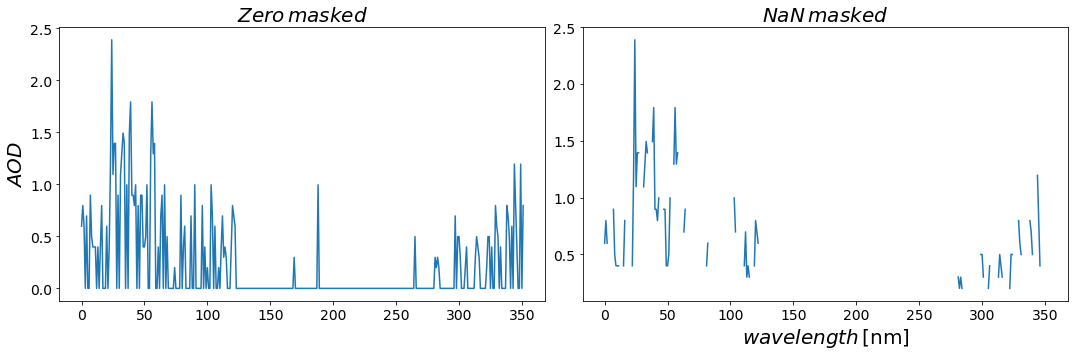

In [6]:
# ******** INPUT PARAMETERS ************
filename = 'OMI_ANU_2016.txt'
AOD_obs = np.array(np.loadtxt('%s' %filename, skiprows=0, usecols=1))
a = scaled_AOD(alpha=0.044, AOD_old=AOD_obs,lambda_old=500, lambda_new=550)
set_font_size = [20, 14]
# ******** INPUT PARAMETERS ************

U = a[0] > 0 
print U
m = U*a[0]
w1 = np.where(m > 0, m, np.NaN)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(U*a[0])
ax[1].plot(w1)
ax[1].set_xlabel(r'$wavelength \, \rm [nm] $', fontsize=set_font_size[0])
ax[1].set_title(r'$ NaN \, masked $', fontsize=set_font_size[0])
ax[0].set_ylabel(r'$ AOD $', fontsize=set_font_size[0])
ax[0].set_title(r'$ Zero \, masked $', fontsize=set_font_size[0])
# plt.subplots_adjust(wspace=0.2, hspace=0.05)
plt.tight_layout()
for c in xrange(2):
    for tick in ax[c].xaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1]) 
    for tick in ax[c].yaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

#### 1.2 Measured scaled AOD from 500 - 550 nm

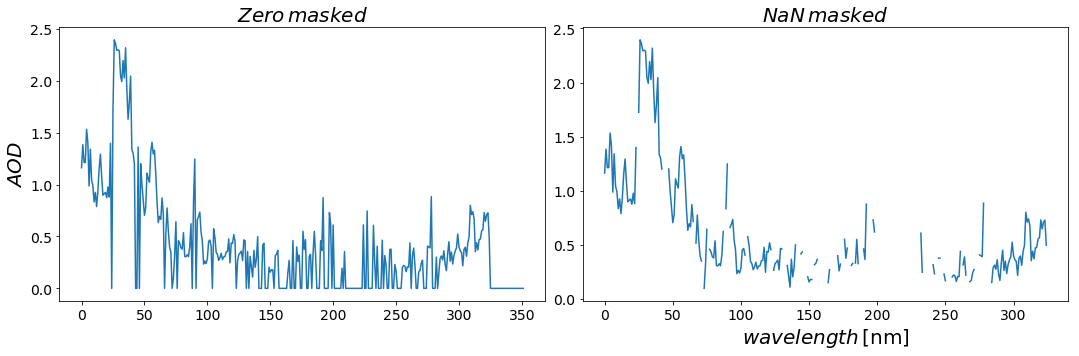

In [7]:
# ******** INPUT PARAMETERS ************
filename = 'OMI_ANU_2016.txt'
AOD_obs = np.array(np.loadtxt('%s' %filename, skiprows=0, usecols=2))
a = scaled_AOD(alpha=0.044, AOD_old=AOD_obs,lambda_old=500, lambda_new=550)
set_font_size = [20, 14]
# ******** INPUT PARAMETERS ************

U = a[0] > 0 
m = U*a[0]
w2 = np.where(m > 0, m, np.NaN)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(U*a[0])
ax[1].plot(w2)
ax[1].set_xlabel(r'$wavelength \, \rm [nm] $', fontsize=set_font_size[0])
ax[1].set_title(r'$ NaN \, masked $', fontsize=set_font_size[0])
ax[0].set_ylabel(r'$ AOD $', fontsize=set_font_size[0])
ax[0].set_title(r'$ Zero \, masked $', fontsize=set_font_size[0])
# plt.subplots_adjust(wspace=0.2, hspace=0.05)
plt.tight_layout()
for c in xrange(2):
    for tick in ax[c].xaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1]) 
    for tick in ax[c].yaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

#### 1.3 Removing masked values

[ 1.17284961  0.09568836]
y_fit = 1.17284960797*x + 0.0956883603449
$y_{fit} =1.1728*x + 0.0957$


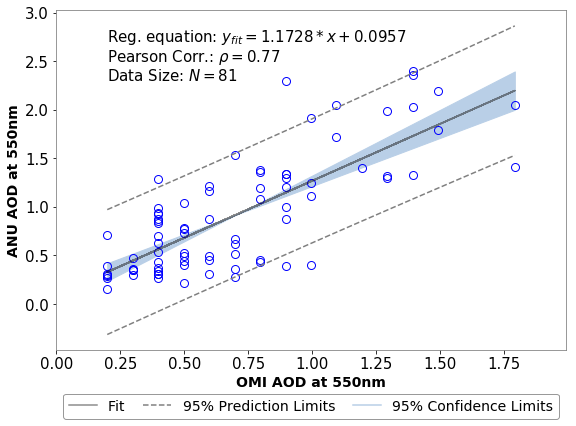

In [8]:
ind1 = np.where(~np.isnan(w1))
w1_a = w1[np.where(~np.isnan(w1))]
w2_a = w2[ind1]

ind2 = np.where(~np.isnan(w2_a))
w2_b = w2_a[np.where(~np.isnan(w2_a))]
w1_b = w1_a[ind2]

heights = w1_b
weights = w2_b

plots(heights, weights, in_text=[0.2, 2.7, 0.2], xlabel='OMI AOD at 550nm', ylabel='ANU AOD at 550nm', add_xlim=[-0.2,0.2])

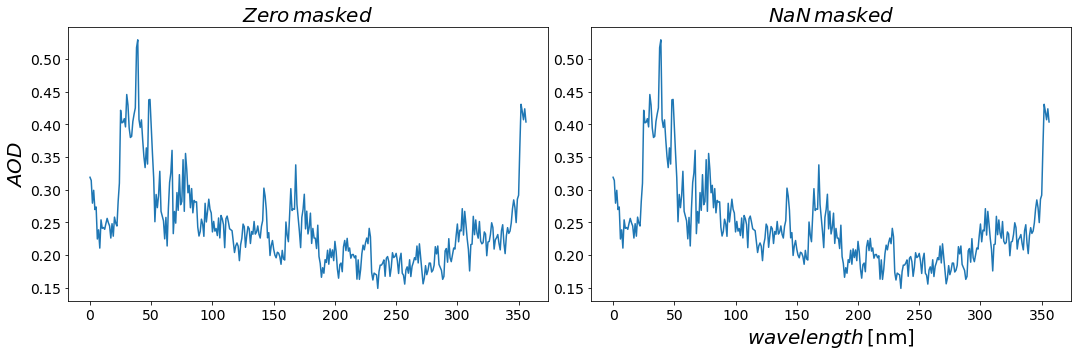

In [9]:
# ******** INPUT PARAMETERS ************
filename = 'mean_mod.txt'
AOD_obs = np.array(np.loadtxt('%s' %filename, skiprows=0, usecols=0))
a = scaled_AOD(alpha=0.044, AOD_old=AOD_obs,lambda_old=550, lambda_new=500)
set_font_size = [20, 14]
# ******** INPUT PARAMETERS ************

U = a[0] > 0 
m = U*a[0]
w3 = np.where(m > 0, m, np.NaN)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(U*a[0])
ax[1].plot(w3)
ax[1].set_xlabel(r'$wavelength \, \rm [nm] $', fontsize=set_font_size[0])
ax[1].set_title(r'$ NaN \, masked $', fontsize=set_font_size[0])
ax[0].set_ylabel(r'$ AOD $', fontsize=set_font_size[0])
ax[0].set_title(r'$ Zero \, masked $', fontsize=set_font_size[0])
# plt.subplots_adjust(wspace=0.2, hspace=0.05)
plt.tight_layout()
for c in xrange(2):
    for tick in ax[c].xaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1]) 
    for tick in ax[c].yaxis.get_major_ticks():
        tick.label.set_fontsize(set_font_size[-1])
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

#### 1.4 Saving the scaled values in .txt file

In [10]:
yt = np.array([w1,w2,w3[:len(w1)]])
np.savetxt(fname='aeronet_data_@550-550-500-a.txt', 
           X=yt.T, fmt='%.4e', delimiter='   ', newline='\n', header='OMI_550   ANU_550    MEAN_MOD_500', footer='', comments='# ')

[ 0.10064137  0.20977953]
y_fit = 0.100641365172*x + 0.209779526042
$y_{fit} =0.1006*x + 0.2098$


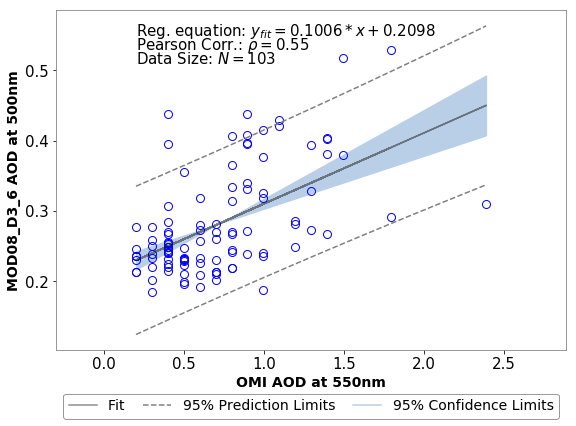

In [11]:
w1_a = w1[np.where(~np.isnan(w1))]
ind1 = np.where(~np.isnan(w1))
w500 = w3[:len(w1)][ind1]

heights = w1_a 
weights = w500

plots(heights, weights, in_text=[0.2, 0.55, 0.02], xlabel='OMI AOD at 550nm', ylabel='MOD08_D3_6 AOD at 500nm', add_xlim=[-0.5,0.5])

### Comparing @ 500

[ 1.17284961  0.09609049]
y_fit = 1.17284960797*x + 0.0960904862353
$y_{fit} =1.1728*x + 0.0961$


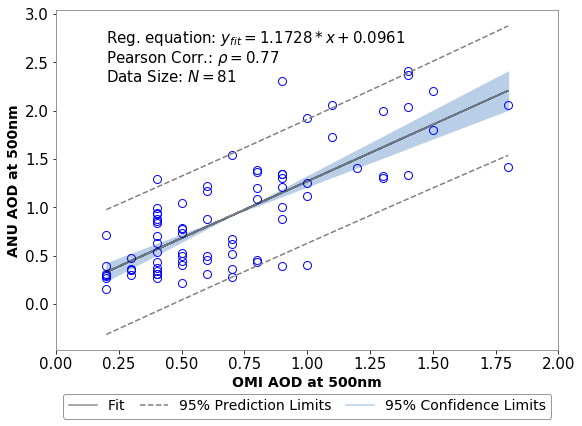

In [12]:
filename = 'OMI_ANU_2016.txt'
AOD_obs = np.array(np.loadtxt('%s' %filename, skiprows=0, usecols=1))
# print AOD_obs
U = AOD_obs > 0 
m = U*AOD_obs
wobs = np.where(m > 0, m, np.NaN)
# wobs

AOD_msrd = np.array(np.loadtxt('%s' %filename, skiprows=0, usecols=2))
# print AOD_obs
U = AOD_msrd > 0 
m = U*AOD_msrd
wmsrd = np.where(m > 0, m, np.NaN)

ind1 = np.where(~np.isnan(wobs))
wa = wobs[np.where(~np.isnan(wobs))]
wb = wmsrd[ind1]

ind2 = np.where(~np.isnan(wb))
wbb = wb[np.where(~np.isnan(wb))]
waa = wa[ind2]

heights = waa
weights = wbb
# print waa
# print wbb
plots(heights, weights, in_text=[0.2, 2.7, 0.2], xlabel='OMI AOD at 500nm', ylabel='ANU AOD at 500nm', add_xlim=[-0.2,0.2])

In [14]:
# w1_a = w1[np.where(~np.isnan(w1))]
# ind1 = np.where(~np.isnan(w1))
# w500 = w3[:len(w1)][ind1]